# Εργασία 9

In [1]:
%pip install swig
%pip install gymnasium[box2d]
%pip install renderlab
%pip install "moviepy<2.0"
%pip install opencv-python
%pip install stable_baselines3
%pip install numpy
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Ερώτηση 2

In [ ]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
episode_over = False
total_reward = 0
while not episode_over:
		# this is where you would insert your policy
		action = env.action_space.sample()

		# step (transition) through the environment with the action
		# receiving the next observation, reward and if the episode has terminated or truncated
		observation, reward, terminated, truncated, info = env.step(action)

		total_reward += reward
		episode_over = terminated or truncated


print(f"Episode finished! Total reward: {total_reward}")
env.close()

- step: τρέχει την επόμενη χρονική στιγμή
- reset: επαναφέρει το περιβάλλον στην αρχική του κατάσταση, έχει και κάποια τυχαιότητα
- render: είναι η εντολή που υπολογίζει τα frame. Αν το render-mode είναι human τότε το rendering υλοποιείται μέσω της step

## Ερώτηση 3
- Observation space: Περιγράφει τι βλέπει ο agent
- Action space: περιγράφει τι κινήσεις που μπορεί να κάνει ο agent
- Reward function: είναι η συνάρτηση με την οποία επιβραβεύεται ο agent 

In [ ]:
# Initialise the environment
import gymnasium as gym
import numpy as np
env = gym.make( "LunarLander-v3", render_mode = None )

# Reset the environment to generate the first observation
total_rewards = []
for _ in range(5):
	observation, info = env.reset(seed=42)
	episode_over = False
	total_reward = 0
	while not episode_over:
		# this is where you would insert your policy
		action = env.action_space.sample()

		# step (transition) through the environment with the action
		# receiving the next observation, reward and if the episode has terminated or truncated
		observation, reward, terminated, truncated, info = env.step(action)

		total_reward += reward
		episode_over = terminated or truncated
	
	total_rewards.append( total_reward )

	mean_reward = np.array( total_rewards ).mean()



print(f"Episodes finished! Mean reward: {mean_reward}")
env.close()

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback
checkpoint_callback = CheckpointCallback( 
	save_freq = 1000,
	save_path = "./logs_dqn/",
	name_prefix = "dqn_model"
)

class HeartbeatCallback(BaseCallback):
	def __init__(self, check_freq=100, verbose=1):
		super().__init__(verbose)
		self.check_freq = check_freq

	def _on_step(self) -> bool:
		# Print every 100 steps so you know it's ALIVE
		if self.n_calls % self.check_freq == 0:
				print(f"Training... Step {self.n_calls} / {self.locals['total_timesteps']}")
		return True
class TimePenaltyWrapper(gym.RewardWrapper):
	def __init__(self, env, penalty=-0.3, truncation_penalty = -100 ):
		super().__init__(env)
		self.penalty = penalty
		self.truncation_penalty = truncation_penalty

	def step(self, action):
		observation, reward, terminated, truncated, info = self.env.step(action)

		if truncated:
			reward += self.truncation_penalty

		return observation, reward, terminated, truncated, info

	def reward(self, reward):
		return reward + self.penalty

n_envs = 4
log_dir = "monitor_dqn_logs/"
env_dqn = make_vec_env("LunarLander-v3", n_envs=n_envs, seed=0, monitor_dir=log_dir, 
											 wrapper_class=TimePenaltyWrapper,
    wrapper_kwargs={"penalty": -1., "truncation_penalty": -100} )


model_dqn = DQN( "MlpPolicy", env_dqn, verbose=1,
								exploration_fraction=0.3,
								exploration_initial_eps = 1.,
								exploration_final_eps = 0.02,
								gamma = 0.99,
								learning_rate = 0.0005,
								tau = 0.8,
								buffer_size=100000,
								policy_kwargs=dict(net_arch=[256, 256]),
								)

model_dqn.learn( total_timesteps=1e7, callback = [checkpoint_callback] )
# model_dqn.save( "dqn_lunarlander" )
mean_reward, std_reward = evaluate_policy( model_dqn, model_dqn.get_env(), n_eval_episodes=10 )
env_dqn.close()


Using cuda device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.5     |
|    ep_rew_mean      | -86      |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5717     |
|    time_elapsed     | 0        |
|    total_timesteps  | 484      |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 4.08     |
|    n_updates        | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.5     |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5705     |
|    time_elapsed     | 0        |
|    total_timesteps  | 864      |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.908    |
| 

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback( 
	save_freq = 1000,
	save_path = "./logs_ppo/",
	name_prefix = "ppo_model"
)

class HeartbeatCallback(BaseCallback):
	def __init__(self, check_freq=100, verbose=1):
		super().__init__(verbose)
		self.check_freq = check_freq

	def _on_step(self) -> bool:
		# Print every 100 steps so you know it's ALIVE
		if self.n_calls % self.check_freq == 0:
				print(f"Training... Step {self.n_calls} / {self.locals['total_timesteps']}")
		return True
class TimePenaltyWrapper(gym.RewardWrapper):
	def __init__(self, env, penalty=-0.3, truncation_penalty = -100 ):
		super().__init__(env)
		self.penalty = penalty
		self.truncation_penalty = truncation_penalty

	def step(self, action):
		observation, reward, terminated, truncated, info = self.env.step(action)

		if truncated:
			reward += self.truncation_penalty

		return observation, reward, terminated, truncated, info

	def reward(self, reward):
		return reward + self.penalty

n_envs = 4
log_dir = "monitor_ppo_logs/"
env_ppo = make_vec_env("LunarLander-v3", n_envs=n_envs, seed=0, monitor_dir=log_dir, 
											 wrapper_class=TimePenaltyWrapper,
    wrapper_kwargs={"penalty": -1., "truncation_penalty": -100} )

# env = gym.make( "LunarLander-v3", render_mode = "rgb_array" )
model = PPO("MlpPolicy", env_ppo, verbose=1)
model.learn(total_timesteps=int(2e6),  callback = [checkpoint_callback])
env_ppo.close()

Using cuda device


/home/markos/Development/ai_assignments/machine_learning_assignments/.venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 89.3     |
|    ep_rew_mean     | -188     |
| time/              |          |
|    fps             | 4694     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 110          |
|    ep_rew_mean          | -166         |
| time/                   |              |
|    fps                  | 2945         |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0073853494 |
|    clip_fraction        | 0.0359       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -0.00451     |
|    learning_r

KeyboardInterrupt: 

In [6]:
def env_loop( env, iters_num, model ):
	total_rewards = []
	for _ in range(iters_num):
		observation, info = env.reset()
		episode_over = False
		total_reward = 0
		while not episode_over:
			# this is where you would insert your policy
			action, _states = model.predict(observation)

			# step (transition) through the environment with the action
			# receiving the next observation, reward and if the episode has terminated or truncated
			observation, reward, terminated, truncated, info = env.step(action)
			total_reward += reward
			episode_over = terminated or truncated
		total_rewards.append( total_reward )
	env.close()

	return total_rewards

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy

def plot_training_results(log_folder, title="Learning Curve"):
	"""
	Plots the learning curve from a Monitor log file.
	"""
	# 1. Load the data using SB3's helper
	# x = timesteps, y = rewards
	x, y = ts2xy(load_results(log_folder), 'timesteps')
	
	# 2. Create a Pandas Series to calculate the Moving Average
	# This smooths out the noise so you can see the trend
	window_size = 100
	y_smoothed = pd.Series(y).rolling(window=window_size).mean()

	# 3. Plot
	plt.figure(figsize=(10, 5))
	plt.title(title)
	plt.xlabel('Timesteps')
	plt.ylabel('Episode Reward')
	
	# Plot the raw noisy data (faint)
	plt.plot(x, y, alpha=0.3, color='gray', label='Raw Reward')
	
	# Plot the smoothed trend (solid)
	plt.plot(x, y_smoothed, color='blue', linewidth=2, label=f'Moving Avg ({window_size})')
	
	# Add the "Solved" threshold line
	plt.axhline(y=200, color='red', linestyle='--', label='Solved (>200)')
	
	plt.legend()
	plt.grid(True)
	plt.show()

In [4]:
import glob
import os

def get_newest_file(directory_path, extension="*"):
	"""
	Returns the path to the most recently modified file in a directory.
	
	Args:
			directory_path: Path to the folder (e.g., "./logs_dqn/")
			extension: Filter by file type (e.g., "*.zip" or "*.mp4"). Default is all files.
	"""
	# 1. Get a list of all files matching the pattern
	search_path = os.path.join(directory_path, extension)
	list_of_files = glob.glob(search_path)
	
	# 2. Check if the directory is empty
	if not list_of_files:
			print(f"No files found in {directory_path} with extension {extension}")
			return None

	# 3. Find the file with the latest creation/modification time
	# os.path.getctime = Creation Time (Windows) or Metadata Change Time (Unix)
	# os.path.getmtime = Modification Time (Works consistently on both)
	latest_file = max(list_of_files, key=os.path.getmtime)
	
	return latest_file

DQN_mean reward: 163.75379227093694


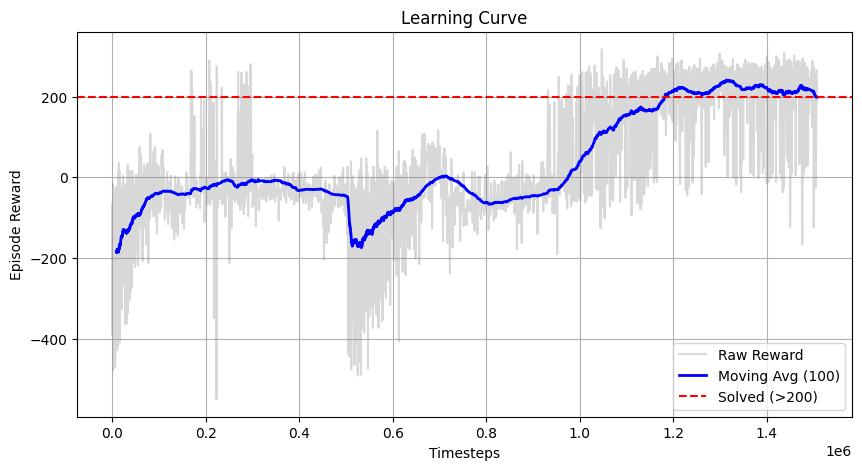

In [ ]:
import numpy as np
from stable_baselines3.common.monitor import Monitor

dqn_model = DQN.load( get_newest_file( "logs_dqn/" ) )
# ppo_model = PPO.load( "ppo_lunarlander" )

env = gym.make("LunarLander-v3", render_mode="human")

dqn_rewards = env_loop( env, 3, dqn_model )
# ppo_rewards = env_loop( env, 5, ppo_model )

dqn_mean = np.array( dqn_rewards ).mean()
# ppo_mean = np.array( ppo_rewards ).mean()

print(f"DQN_mean reward: {dqn_mean}")
plot_training_results("./monitor_dqn_logs/")
# print(f"PPO_mean reward: {ppo_mean}")

/home/markos/Development/ai_assignments/machine_learning_assignments/.venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


PPO_mean reward: 265.4419733510753


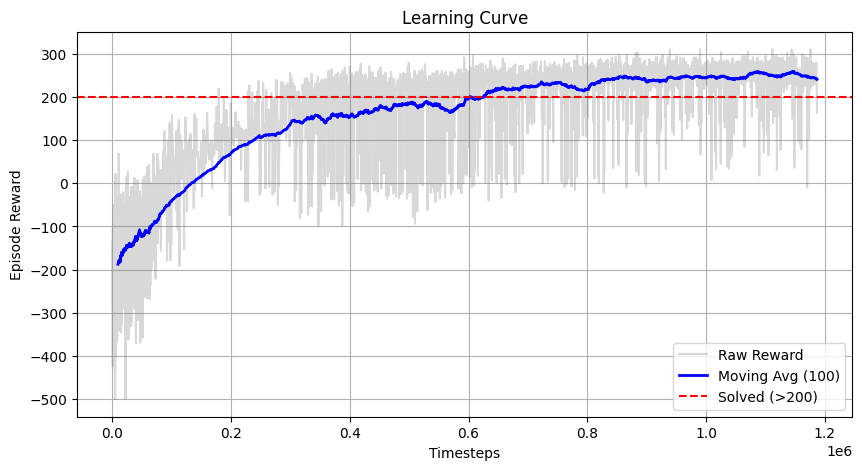

In [15]:
import numpy as np
from stable_baselines3.common.monitor import Monitor

ppo_model = PPO.load( get_newest_file( "logs_ppo/" ) )

env = gym.make("LunarLander-v3", render_mode="human")

ppo_rewards = env_loop( env, 3, ppo_model )

ppo_mean = np.array( ppo_rewards ).mean()
# ppo_mean = np.array( ppo_rewards ).mean()

print(f"PPO_mean reward: {ppo_mean}")
plot_training_results("./monitor_ppo_logs/")

# Ερώτημα 4
Δεν χρειάστηκε να υλοποιηθεί ο random agent για τον λόγο ότι η sample συνάρτηση αρκεί. Το renderlab προκαλούσε προβλήματα σστο περιβάλλον εργασίας όποτε δεν το έβαλα

# Ερώτημα 5-8
Έγινε optimize το πρόβλημα για τον αλγόριθμο dqn. Αυτό έγινε μέσω του learning rate και τοτ exploitation. Για να μπορέσει ο αλγόριθμος να τερματίζει πιο γρήγορα υλοποιήθηκε penalty για κάθε time step και αν τερμάτιζε χωρίς να κάνει τίποτα μπήκε penalty -100. Αυτό έγινε γιατί το διαστημόπλοιο απλά αιωρούταν μέχρι να τελειώσει η πίστα. Με αυτά τα penalty δεν χρειάστηκε να γίνουν αλλαγές για το PPO.